In [1]:
from sklearn import preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.svm import SVR
import lightgbm as lgb
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import KFold,cross_validate
from xgboost import XGBRegressor as xc
from hyperopt import hp,fmin,tpe,Trials,partial
from hyperopt.early_stop import no_progress_loss

In [2]:
## read trainset
df=pd.read_csv('../../data/features_trainset_NoMgZnCa2.csv')
del df['Unnamed: 0']
del df['pretty_formula']
print('data shape：',df.shape)
df.drop_duplicates(subset=['composition'], inplace=True)
print('data shape：',df.shape)
df=df.dropna(axis=1)
df=df.dropna(axis=0)
col_list=df.columns
col_name=col_list[2:len(col_list)]
featur=df[col_name].values
target=df['D_max'].values
X=featur
Y=target
del df['composition']
print('data shape：',df.shape)
df.head()

data shape： (6197, 31)
data shape： (6197, 31)
data shape： (6197, 30)


,D_max,mean simul. packing efficiency,mean abs simul. packing efficiency,dist from 1 clusters |APE| < 0.010,PymatgenData mean X,PymatgenData std_dev X,PymatgenData mean group,PymatgenData std_dev group,PymatgenData mean block,PymatgenData std_dev block,...,PymatgenData std_dev melting_point,Miedema_deltaH_amor,frac s valence electrons,frac p valence electrons,frac d valence electrons,frac f valence electrons,Yang omega,Yang delta,Miedema_deltaH_ami,Miedema_deltaH_am_min
0,10.0,0.020896,0.020896,0.033501,2.03290,0.185815,10.900,2.521879,2.820,0.504376,...,728.967432,-0.500310,0.164835,0.059341,0.775824,0.000000,0.586617,0.103001,0.126936,-0.094334
1,10.0,0.000670,0.006834,0.043716,2.12590,0.200782,10.700,2.216309,2.850,0.558197,...,241.442175,-0.130057,0.043478,0.032609,0.923913,0.000000,0.392351,0.086070,0.080354,0.028428
2,10.0,-0.015556,0.018724,0.022007,2.18428,0.188610,11.272,2.643745,2.775,0.541661,...,905.835248,-0.490239,0.074859,0.039538,0.414070,0.471532,0.528908,0.116458,0.115555,-0.062043
3,10.0,-0.005988,0.016611,0.063541,1.74220,0.322230,7.420,4.157678,2.980,0.168005,...,401.501511,-0.937599,0.185984,0.005391,0.808625,0.000000,0.595838,0.073392,0.170738,-0.107714
4,10.0,0.010147,0.014896,0.030179,1.58170,0.207650,4.840,3.396469,2.600,0.946895,...,283.590679,-0.716688,0.392562,0.000000,0.607438,0.000000,0.766083,0.111325,0.146034,-0.103214


In [3]:
##normalization
y = df['D_max']

scaler=preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_scaled.shape

(6197, 29)

In [ ]:
##RF
param_grid = {
    'n_estimators':hp.quniform('n_estimators',50,550,5),
    'max_features':hp.quniform('max_features',3,29,1),
    'max_depth':hp.quniform('max_depth',8,55,1),
    'min_samples_split':hp.quniform('min_samples_split',2,10,1),
    'min_impurity_decrease':hp.quniform("min_impurity_decrease",0,5,0.1)
}

def hyperopt_objective(params):
    reg = RFR(n_estimators=int(params['n_estimators']),
             max_depth=int(params['max_depth']),
             max_features=int(params['max_features']),
             min_samples_split=int(params['min_samples_split']),
             min_impurity_decrease=params['min_impurity_decrease'],
             random_state = 12138,
             verbose = False,
             n_jobs=10)
    cv = KFold(n_splits=5,shuffle=True,random_state=12138)
    validation_loss = cross_validate(reg,X_scaled,y,scoring='neg_root_mean_squared_error',cv=cv,
                                    verbose=False,n_jobs=10,error_score='raise')
    return np.mean(abs(validation_loss['test_score']))

def param_hyperopt(max_evals=100):

    trials = Trials()
    early_stop_fn = no_progress_loss(100)
    params_best =fmin(hyperopt_objective,
                     space = param_grid,
                     algo = tpe.suggest,
                     max_evals = max_evals,
                     verbose = True,
                     trials = trials,
                     early_stop_fn = early_stop_fn
                     )

    print('\n','best params:',params_best,'\n')
    return params_best,trials

def hyperopt_validation(params):
    reg = RFR(n_estimators=int(params['n_estimators']),
             max_depth=int(params['max_depth']),
             max_features=int(params['max_features']),
             min_samples_split=int(params['min_samples_split']),
             min_impurity_decrease=int(params['min_impurity_decrease']),
             random_state =12138,
             verbose = False,
             n_jobs=-1)
    cv = KFold(n_splits=5,shuffle=True,random_state=2)
    validation_loss = cross_validate(reg,X_scaled,y,scoring='r2',cv=cv,
                                    verbose=False,n_jobs=-1,error_score='raise')
    return np.mean(abs(validation_loss['test_score']))

In [ ]:
params_best,trials = param_hyperopt(500) 
hyperopt_validation(params_best)

In [ ]:
params_best,trials = param_hyperopt(500) 
hyperopt_validation(params_best)

In [ ]:
params_best,trials = param_hyperopt(500) 
hyperopt_validation(params_best)

49%|██████████████████████▌                       | 245/500 [09:46<10:09,  2.39s/trial, best loss: 0.7195518940393366]

 best params: {'max_depth': 29.0, 'max_features': 6.0, 'min_impurity_decrease': 0.0, 'min_samples_split': 2.0, 'n_estimators': 250.0} 

0.774395382470881

In [ ]:
##SVM
param_grid = {
    'C':hp.quniform('C',1,50,1),
    'gamma':hp.quniform('gamma',0.1,0.45,0.005),
    'epsilon':hp.quniform('epsilon',0,0.2,0.002)
}

def hyperopt_objective(params):
    reg = SVR(C=int(params['C']),
             epsilon=params['epsilon'],
             gamma=params['gamma'],
             kernel='rbf',
             verbose = False
             )
    cv = KFold(n_splits=5,shuffle=True,random_state=12138)
    validation_loss = cross_validate(reg,X_scaled,y,scoring='neg_root_mean_squared_error',cv=cv,
                                    verbose=False,n_jobs=-1,error_score='raise')
    return np.mean(abs(validation_loss['test_score']))

def param_hyperopt(max_evals=100):
    trials = Trials()
    early_stop_fn = no_progress_loss(100)
    params_best =fmin(hyperopt_objective,
                     space = param_grid,
                     algo = tpe.suggest,
                     max_evals = max_evals,
                     verbose = True,
                     trials = trials,
                     early_stop_fn = early_stop_fn
                     )
    print('\n','best params:',params_best,'\n')
    return params_best,trials

def hyperopt_validation(params):
    reg = SVR(C=int(params['C']),
             epsilon=params['epsilon'],
             gamma=params['gamma'],
             kernel='rbf',
             verbose = False)
    cv = KFold(n_splits=5,shuffle=True,random_state=2)
    validation_loss = cross_validate(reg,X_scaled,y,scoring='r2',cv=cv,
                                    verbose=False,n_jobs=-1,error_score='raise')
    return np.mean(abs(validation_loss['test_score']))

In [ ]:
params_best,trials = param_hyperopt(500) 
hyperopt_validation(params_best)

In [ ]:
params_best,trials = param_hyperopt(500) 
hyperopt_validation(params_best)

In [ ]:
params_best,trials = param_hyperopt(500)
hyperopt_validation(params_best)

35%|████████████████▎                             | 177/500 [15:25<28:08,  5.23s/trial, best loss: 0.7316691695397235]

 best params: {'C': 7.0, 'epsilon': 0.006, 'gamma': 0.29} 

0.7637258294865948

In [ ]:
##XGBoost
def hyperopt_objective(params):
    reg = xc(n_estimators=int(params['n_estimators']),
             max_depth=int(params['max_depth']),
             reg_lambda=params['reg_lambda'],
             learning_rate=params['learning_rate'],
             subsample=params['subsample'],
             colsample_bytree=params['colsample_bytree'],
             colsample_bynode=params['colsample_bynode'],
             gamma = params['gamma'],
             min_child_weight=params['min_child_weight'],
             objective='reg:squarederror',
             random_state = 12138,
             n_jobs=-1)
    cv = KFold(n_splits=5,shuffle=True,random_state=12138)
    validation_loss = cross_validate(reg,X_scaled,y,scoring='neg_root_mean_squared_error',cv=cv,
                                    verbose=False,n_jobs=-1,error_score='raise')
    return np.mean(abs(validation_loss['test_score']))

param_grid_simple = {'n_estimators': hp.quniform("n_estimators",150,450,3)
                     ,"learning_rate": hp.quniform("learning_rate",0.05,0.3,0.002)
                     ,"colsample_bytree":hp.quniform("colsample_bytree",0.3,1,0.1)
                     ,"colsample_bynode":hp.quniform("colsample_bynode",0.1,1,0.1)
                     ,"gamma":hp.quniform("gamma",0,15,0.2)
                     ,"reg_lambda":hp.quniform("reg_lambda",0,25,0.5)
                     ,"min_child_weight":hp.quniform("min_child_weight",0,50,0.5)
                     ,"max_depth":hp.quniform("max_depth",5,45,1)
                     ,"subsample":hp.quniform("subsample",0.5,1,0.1)
                    }

def param_hyperopt(max_evals=100):

    trials = Trials()
    early_stop_fn = no_progress_loss(100)
    params_best = fmin(hyperopt_objective
                       , space = param_grid_simple
                       , algo = tpe.suggest
                       , max_evals = max_evals
                       , verbose=True
                       , trials = trials
                       , early_stop_fn = early_stop_fn
                      )
    print("\n","\n","best params: ", params_best,
          "\n")
    return params_best, trials

def hyperopt_validation(params):
    reg = xc(n_estimators=int(params['n_estimators']),
             max_depth=int(params['max_depth']),
             reg_lambda=params['reg_lambda'],
             learning_rate=params['learning_rate'],
             subsample=params['subsample'],
             colsample_bytree=params['colsample_bytree'],
             colsample_bynode=params['colsample_bynode'],
             gamma = params['gamma'],
             min_child_weight=params['min_child_weight'],
             objective='reg:squarederror',
             random_state = 12138,
             n_jobs=-1)
    cv = KFold(n_splits=5,shuffle=True,random_state=2)
    validation_loss = cross_validate(reg,X_scaled,y,scoring='r2',cv=cv,
                                    verbose=False,n_jobs=-1,error_score='raise')
    return np.mean(abs(validation_loss['test_score']))

In [ ]:
params_best,trials = param_hyperopt(500) 
hyperopt_validation(params_best)

In [ ]:
params_best,trials = param_hyperopt(500) 
hyperopt_validation(params_best)

In [ ]:
params_best,trials = param_hyperopt(500) 
hyperopt_validation(params_best)

 37%|█████████████████                             | 186/500 [24:30<41:22,  7.91s/trial, best loss: 0.6738492668255764]

 
 best params:  {'colsample_bynode': 0.30000000000000004, 'colsample_bytree': 0.7000000000000001, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 38.0, 'min_child_weight': 12.0, 'n_estimators': 330.0, 'reg_lambda': 5.5, 'subsample': 0.9} 

0.8006632973488019

In [ ]:
##LightGBM
param_grid = {
    'n_estimators':hp.quniform('n_estimators',100,800,5),
    'num_leaves':hp.quniform('num_leaves',10,400,5),
    'learning_rate':hp.quniform('learning_rate',0.1,0.5,0.02),
    'min_child_samples':hp.quniform('min_child_samples',1,40,1),
    'reg_alpha':hp.quniform("reg_alpha",0,10,0.5),
    'reg_lambda':hp.quniform("reg_lambda",0,100,2),
    'subsample':hp.quniform("subsample",0.5,1,0.1)
}

def hyperopt_objective(params):
    reg = lgb.LGBMRegressor(
             n_estimators=int(params['n_estimators']),
             num_leaves=int(params['num_leaves']),
             min_child_samples=int(params['min_child_samples']),
             learning_rate=params['learning_rate'],
             reg_alpha=params['reg_alpha'],
             reg_lambda=params['reg_lambda'], 
             subsample = params['subsample'],
             random_state = 12138,
             verbose = int(False),
             n_jobs=-1)
    cv = KFold(n_splits=5,shuffle=True,random_state=12138)
    validation_loss = cross_validate(reg,X_scaled,y,scoring='neg_root_mean_squared_error',cv=cv,
                                    verbose=False,n_jobs=-1,error_score='raise')
    return np.mean(abs(validation_loss['test_score']))

def param_hyperopt(max_evals=100):

    trials = Trials()
    early_stop_fn = no_progress_loss(100)
    params_best =fmin(hyperopt_objective,
                     space = param_grid,
                     algo = tpe.suggest,
                     max_evals = max_evals,
                     verbose = True,
                     trials = trials,
                     early_stop_fn = early_stop_fn
                     )
    print('\n','best params:',params_best,'\n')
    return params_best,trials

def hyperopt_validation(params):
    reg = lgb.LGBMRegressor(
             n_estimators=int(params['n_estimators']),
             num_leaves=int(params['num_leaves']),
             min_child_samples=int(params['min_child_samples']),
             learning_rate=params['learning_rate'],
             reg_alpha=params['reg_alpha'],
             reg_lambda=params['reg_lambda'], 
             subsample = params['subsample'],
             random_state = 12138,
             verbose = int(False),
             n_jobs=-1)
    cv = KFold(n_splits=5,shuffle=True,random_state=2)
    validation_loss = cross_validate(reg,X_scaled,y,scoring='r2',cv=cv,
                                    verbose=False,n_jobs=-1,error_score='raise')
    return np.mean(abs(validation_loss['test_score']))

In [ ]:
params_best,trials = param_hyperopt(500) 
hyperopt_validation(params_best)

In [ ]:
params_best,trials = param_hyperopt(500) 
hyperopt_validation(params_best)

In [ ]:
params_best,trials = param_hyperopt(500) 
hyperopt_validation(params_best)

36%|████████████████▍                             | 178/500 [15:53<28:44,  5.35s/trial, best loss: 0.6881535740363384]

 best params: {'learning_rate': 0.1, 'min_child_samples': 11.0, 'n_estimators': 615.0, 'num_leaves': 280.0, 'reg_alpha': 1.0, 'reg_lambda': 54.0, 'subsample': 0.7000000000000001} 

0.7996922229943271

___

In [4]:
##Fusion
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import train_test_split
import ternary
X_train,X_test,Y_train,Y_test = train_test_split(X_scaled,y,train_size=0.8,random_state=12138)

reg_svm = SVR(C=7,epsilon=0.006,gamma=0.29)
reg_rf = RFR(max_depth=29,max_features=6,min_impurity_decrease=0,min_samples_split=2,n_estimators=250,random_state=12138)
reg_xgb = xc(colsample_bynode=0.4,colsample_bytree=0.7,gamma=0,learning_rate=0.052,max_depth=21,
         min_child_weight=5.5,n_estimators=390,reg_lambda=13,subsample=1,random_state=12138)
reg_gbm = lgb.LGBMRegressor(learning_rate = 0.1,min_child_samples = 11,n_estimators = 615, 
         num_leaves =280,reg_alpha = 1,reg_lambda =54,subsample = 0.7,random_state=12138)
estimators = [('svm',reg_svm), ('rf',reg_rf), ('xgb',reg_xgb), ('lightgbm',reg_gbm)]

In [ ]:
VC_hard =VotingRegressor(estimators).fit(X_train, Y_train)
print('Test',VC_hard.score(X_test,Y_test))
print('Train',VC_hard.score(X_train,Y_train))

reg_rf.fit(X_train, Y_train)
reg_xgb.fit(X_train, Y_train)
reg_svm.fit(X_train, Y_train)
reg_gbm.fit(X_train, Y_train)

print('SVM',reg_svm.score(X_train, Y_train),reg_svm.score(X_test,Y_test))
print('RF',reg_rf.score(X_train, Y_train),reg_rf.score(X_test,Y_test))
print('XGB',reg_xgb.score(X_train, Y_train),reg_xgb.score(X_test,Y_test))
print('LightGBM',reg_gbm.score(X_train, Y_train),reg_gbm.score(X_test,Y_test))

In [ ]:
params_space = {
                'weight1': hp.quniform("weight1",0,1,0.01),
                'weight2': hp.quniform("weight2",0,1,0.01),
                'weight3': hp.quniform("weight3",0,1,0.01),
                'weight4': hp.quniform("weight4",0,1,0.01)
}

def hyperopt_objective_weight(params):
    weight1 = params['weight1']
    weight2 = params['weight2']
    weight3 = params['weight3']
    weight4 = params['weight4']
    weights = [weight1, weight2, weight3,weight4]
    
    reg = VotingRegressor(estimators=estimators, n_jobs=-1,weights=weights)
    cv = KFold(n_splits=5,shuffle=True,random_state=12138)
    validation_loss = cross_validate(reg,X_scaled,y,scoring='r2',cv=cv,
                                    verbose=False,n_jobs=8,error_score='raise')
    return -np.mean(abs(validation_loss['test_score']))

def param_hyperopt(max_evals=100):
    
    trials = Trials()
    early_stop_fn = no_progress_loss(50)
    params_best = fmin(hyperopt_objective_weight
                       , space = params_space
                       , algo = tpe.suggest
                       , max_evals = max_evals
                       , verbose=True
                       , trials = trials
                       , early_stop_fn = early_stop_fn
                      )

    print("\n","\n","best params: ", params_best,
          "\n")
    return params_best, trials

def hyperopt_validation(params):
    reg = VotingRegressor(estimators=estimators,n_jobs=-1,
                          weights=[params[0]['weight1'],params[0]['weight2'],params[0]['weight3'],params[0]['weight4']])
    cv = KFold(n_splits=5,shuffle=True,random_state=2)
    validation_loss = cross_validate(reg,X_scaled,y,scoring='r2',cv=cv,
                                    verbose=False,n_jobs=-1,error_score='raise')
    return np.mean(abs(validation_loss['test_score']))

In [ ]:
params_best = param_hyperopt(300)
hyperopt_validation(params_best)

In [ ]:
params_best = param_hyperopt(300)
hyperopt_validation(params_best)

In [ ]:
params_best = param_hyperopt(300)
hyperopt_validation(params_best)

 29%|█████████████▏                               | 88/300 [30:59<1:14:40, 21.14s/trial, best loss: -0.809967108662678]

 
 best params:  {'weight1': 0.32, 'weight2': 0.0, 'weight3': 0.75, 'weight4': 0.36} 

0.8103815720636611

In [ ]:
weight1 = 0.32
weight2 = 0
weight3 = 0.75
weight4 = 0.36

weights = [weight1, weight2, weight3, weight4]

weight_sum = weight1 + weight2 + weight3 + weight4
X_train,X_test,Y_train,Y_test = train_test_split(X_scaled,y,train_size=0.8,random_state=1213)
Voting_soft_weight = VotingRegressor(estimators=estimators, n_jobs=-1,
                                      weights=weights).fit(X_train, Y_train)
print(Voting_soft_weight.score(X_train, Y_train))
print(Voting_soft_weight.score(X_test, Y_test))

In [5]:
df_feature=pd.read_csv('../../data/features_MgZnCa.csv')
compositions=df_feature['composition']
del df_feature['Unnamed: 0']
del df_feature['composition']
del df_feature['pretty_formula'] 
print('data shape：',df_feature.shape)
df_feature.head()

data shape： (5151, 88)


,mean simul. packing efficiency,mean abs simul. packing efficiency,dist from 1 clusters |APE| < 0.010,dist from 3 clusters |APE| < 0.010,dist from 5 clusters |APE| < 0.010,band center,PymatgenData minimum X,PymatgenData maximum X,PymatgenData range X,PymatgenData mean X,...,avg f valence electrons,frac s valence electrons,frac p valence electrons,frac d valence electrons,frac f valence electrons,Yang omega,Yang delta,Miedema_deltaH_ami,Miedema_deltaH_ams,Miedema_deltaH_am_min
0,0.023994,0.023994,1.000000,1.000000,1.000000,3.068874,1.0,1.00,0.00,1.0000,...,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.040338,0.040338,0.040338
1,0.026525,0.026848,0.174420,0.410300,0.546474,3.081966,1.0,1.65,0.65,1.0065,...,0.0,0.952381,0.0,0.047619,0.0,0.593634,0.030288,0.040186,0.035679,0.035679
2,0.029059,0.029581,0.160278,0.396158,0.532332,3.095114,1.0,1.65,0.65,1.0130,...,0.0,0.909091,0.0,0.090909,0.0,0.522929,0.042747,0.040038,0.031199,0.031199
3,0.031595,0.032192,0.146135,0.382016,0.518190,3.108317,1.0,1.65,0.65,1.0195,...,0.0,0.869565,0.0,0.130435,0.0,0.482225,0.052246,0.039895,0.026892,0.026892
4,-0.033506,0.033506,0.131993,0.367874,0.504048,3.121577,1.0,1.65,0.65,1.0260,...,0.0,0.833333,0.0,0.166667,0.0,0.453739,0.060201,0.039762,0.022751,0.022751


In [6]:
pred_X = df_feature[col_name]
pred_X_transformed=scaler.transform(pred_X)
pred_X_transformed.shape

(5151, 29)

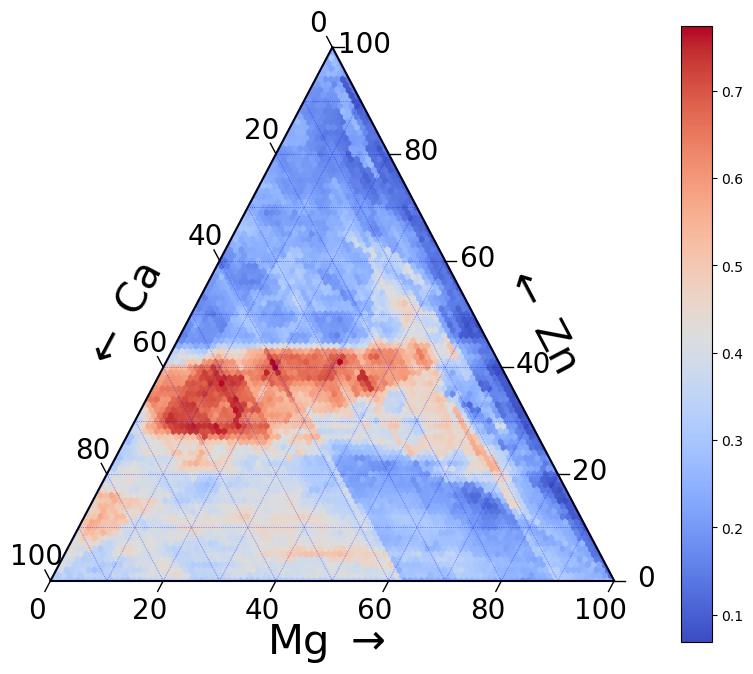

In [7]:
weight1 = 0.32
weight2 = 0
weight3 = 0.75
weight4 = 0.36
weights = [weight1, weight2, weight3, weight4]
Voting_soft_weight = VotingRegressor(estimators=estimators, n_jobs=-1,
                                      weights=weights).fit(X_scaled, y)
weight_sum = weight1 + weight2 + weight3
xxx = Voting_soft_weight.predict(pred_X_transformed)
df_pred_MgZnCa=pd.DataFrame({'pretty_formula':compositions,'pred_D_max':xxx})
df_pred_MgZnCa['pred_D_max'].describe()
df_pred_MgZnCa.to_csv('MgZnCa2_fusion_D_max.csv')
comp_1=[]
comp_2=[]
comp_3=[]
points=[]
for i in range(0,101,1):
    for j in range(0,101-i,1):
        k=100-i-j
        comp_1.append(i)
        comp_2.append(j)
        comp_3.append(k)
        points.append((i,j,k))

D_max=df_pred_MgZnCa['pred_D_max'].values
data=dict()
for x in range(0,len(D_max)):
    data[points[x]]=D_max[x]
    
scale=100
figure,tax = ternary.figure(scale=scale)
figure.set_size_inches((10,8))
figure.set_facecolor('w')
tax.boundary(linewidth=1.5)
tax.gridlines(color='blue',multiple=10,linewidth=0.5,alpha=0.7)
tax.ticks(axis='lbr',linewidth=1,multiple=20,fontsize=20,offset=0.02)

tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

tax.heatmap(data, scale=scale,style="h", vmin=min(D_max), vmax=max(D_max), cmap='coolwarm',use_rgba=False, colorbar=True)
tax.left_axis_label(r"$\leftarrow$ Ca", fontsize=30, offset=0.12)
tax.right_axis_label(r"$\leftarrow$ Zn", fontsize=30, offset=0.12)
tax.bottom_axis_label("Mg "+r"$\rightarrow$", fontsize=30, offset=0.04)
tax.savefig('MgZnCa2_fusion_D_max.jpg',bbox_inches='tight')